**Review**
	  
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job! The project is accepted. Good luck on the next sprint!

In [ ]:
# using BERT with CUDA

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import os
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
def find_file(filename):
    """Returns file path under /datasets directory, if exists, otherwise uses local dir"""
    
    filepath = f'/datasets/{filename}'
    if not os.path.isfile(filepath):
        filepath = filename
        
    return filepath

# find_file(filename)

In [5]:
filename = find_file('imdb_reviews.tsv')

In [6]:
# df_reviews = pd.read_csv(filename, sep='\t', dtype={'votes': 'Int64'})

In [7]:
df_reviews = pd.read_csv('https://code.s3.yandex.net/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [8]:
df_reviews.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [9]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The data was loaded and inspected
	  
</div>

## EDA

Let's check the number of movies and reviews over years.

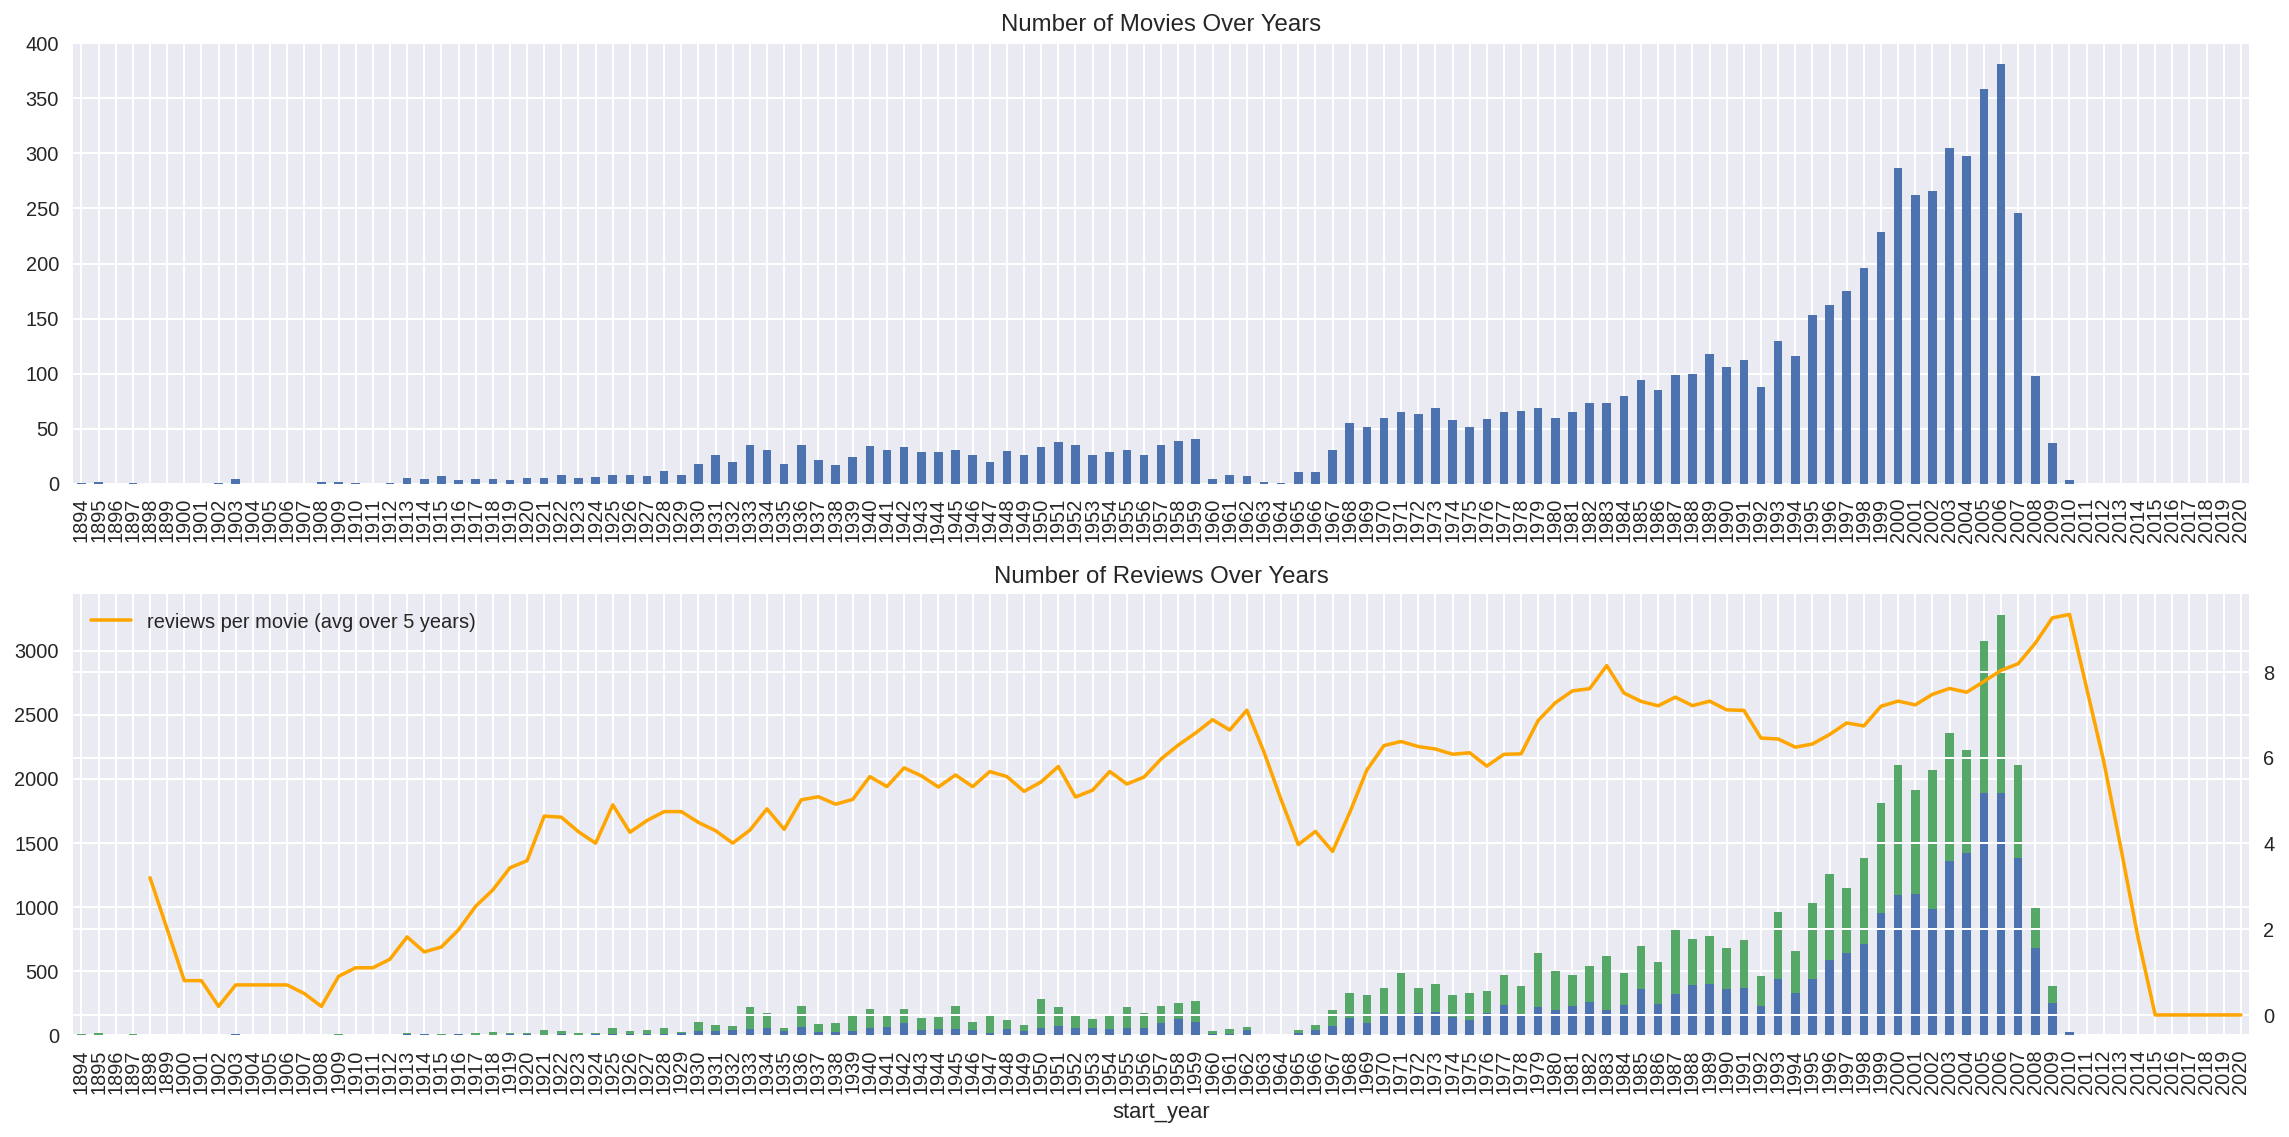

In [80]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

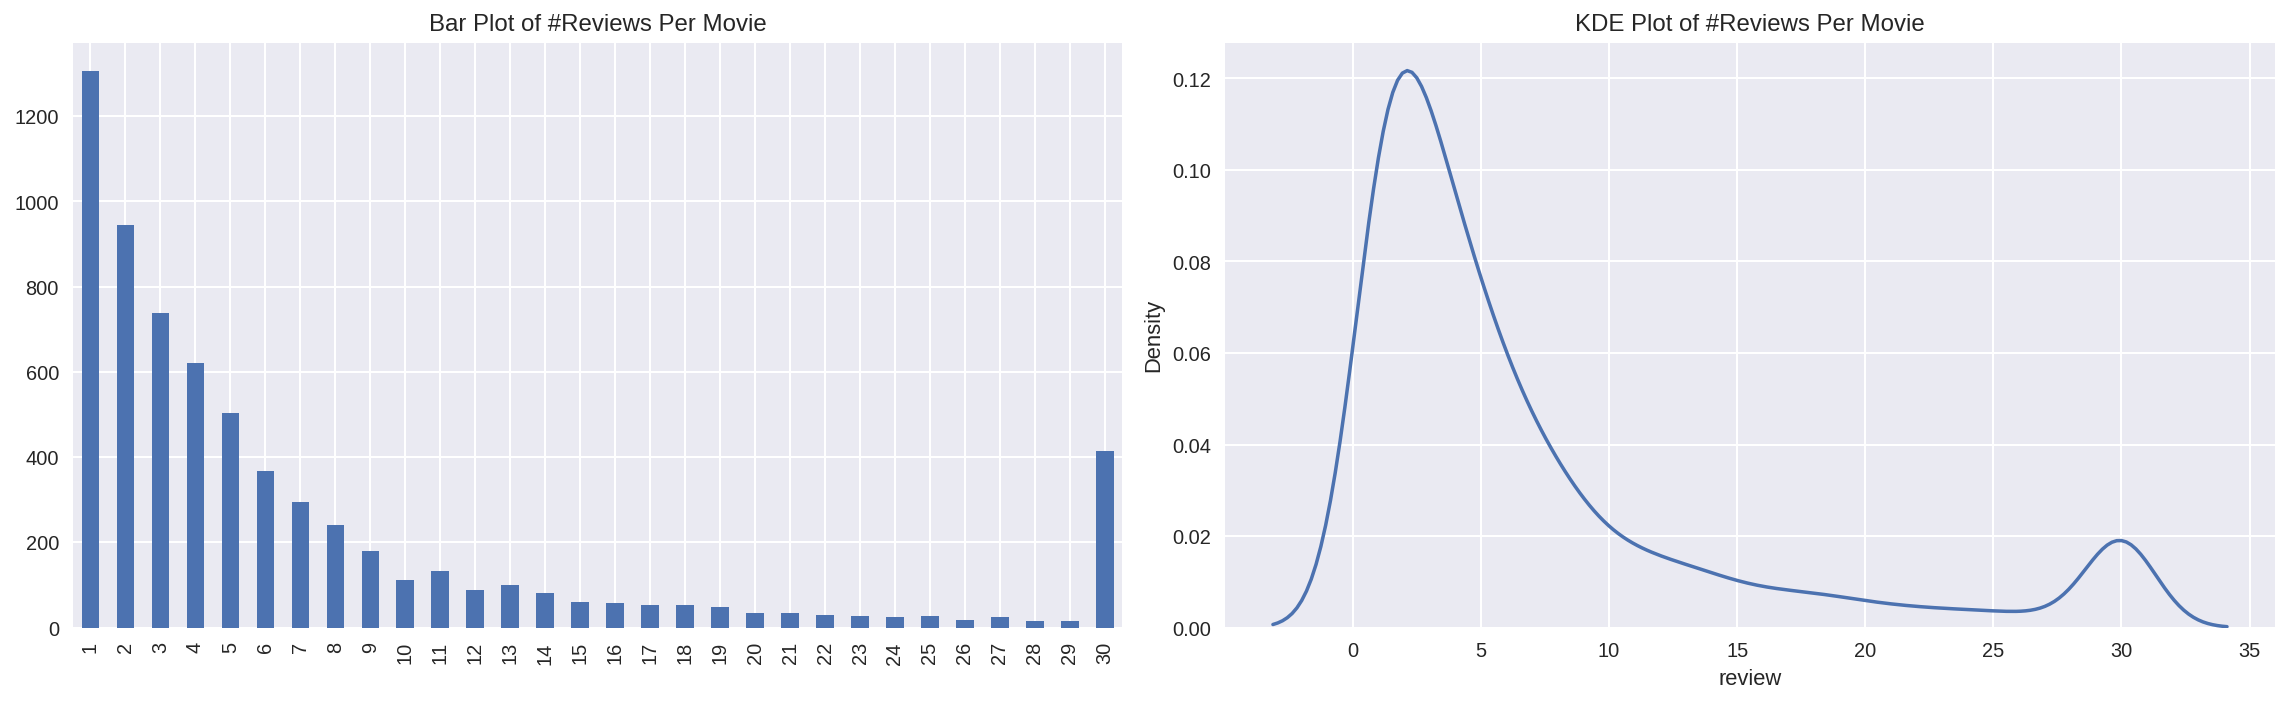

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [85]:
df_reviews['pos'].value_counts(normalize=True)

0    0.501046
1    0.498954
Name: pos, dtype: float64

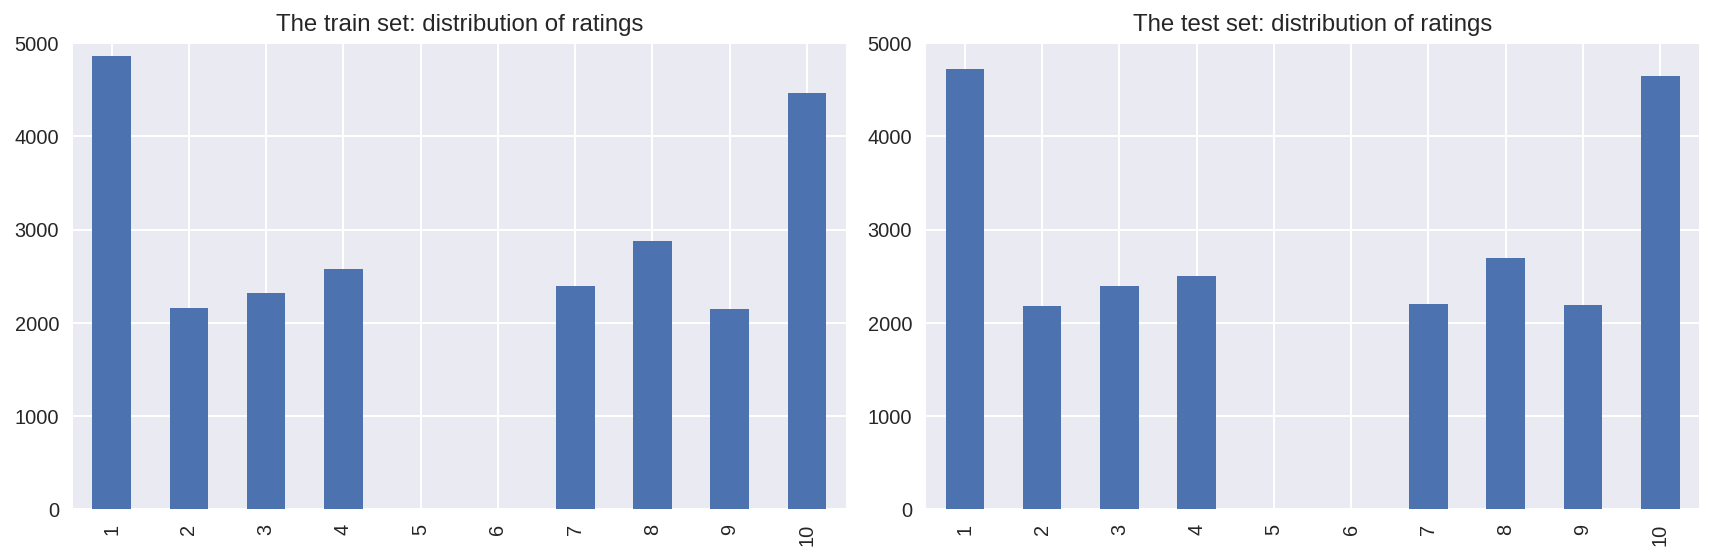

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

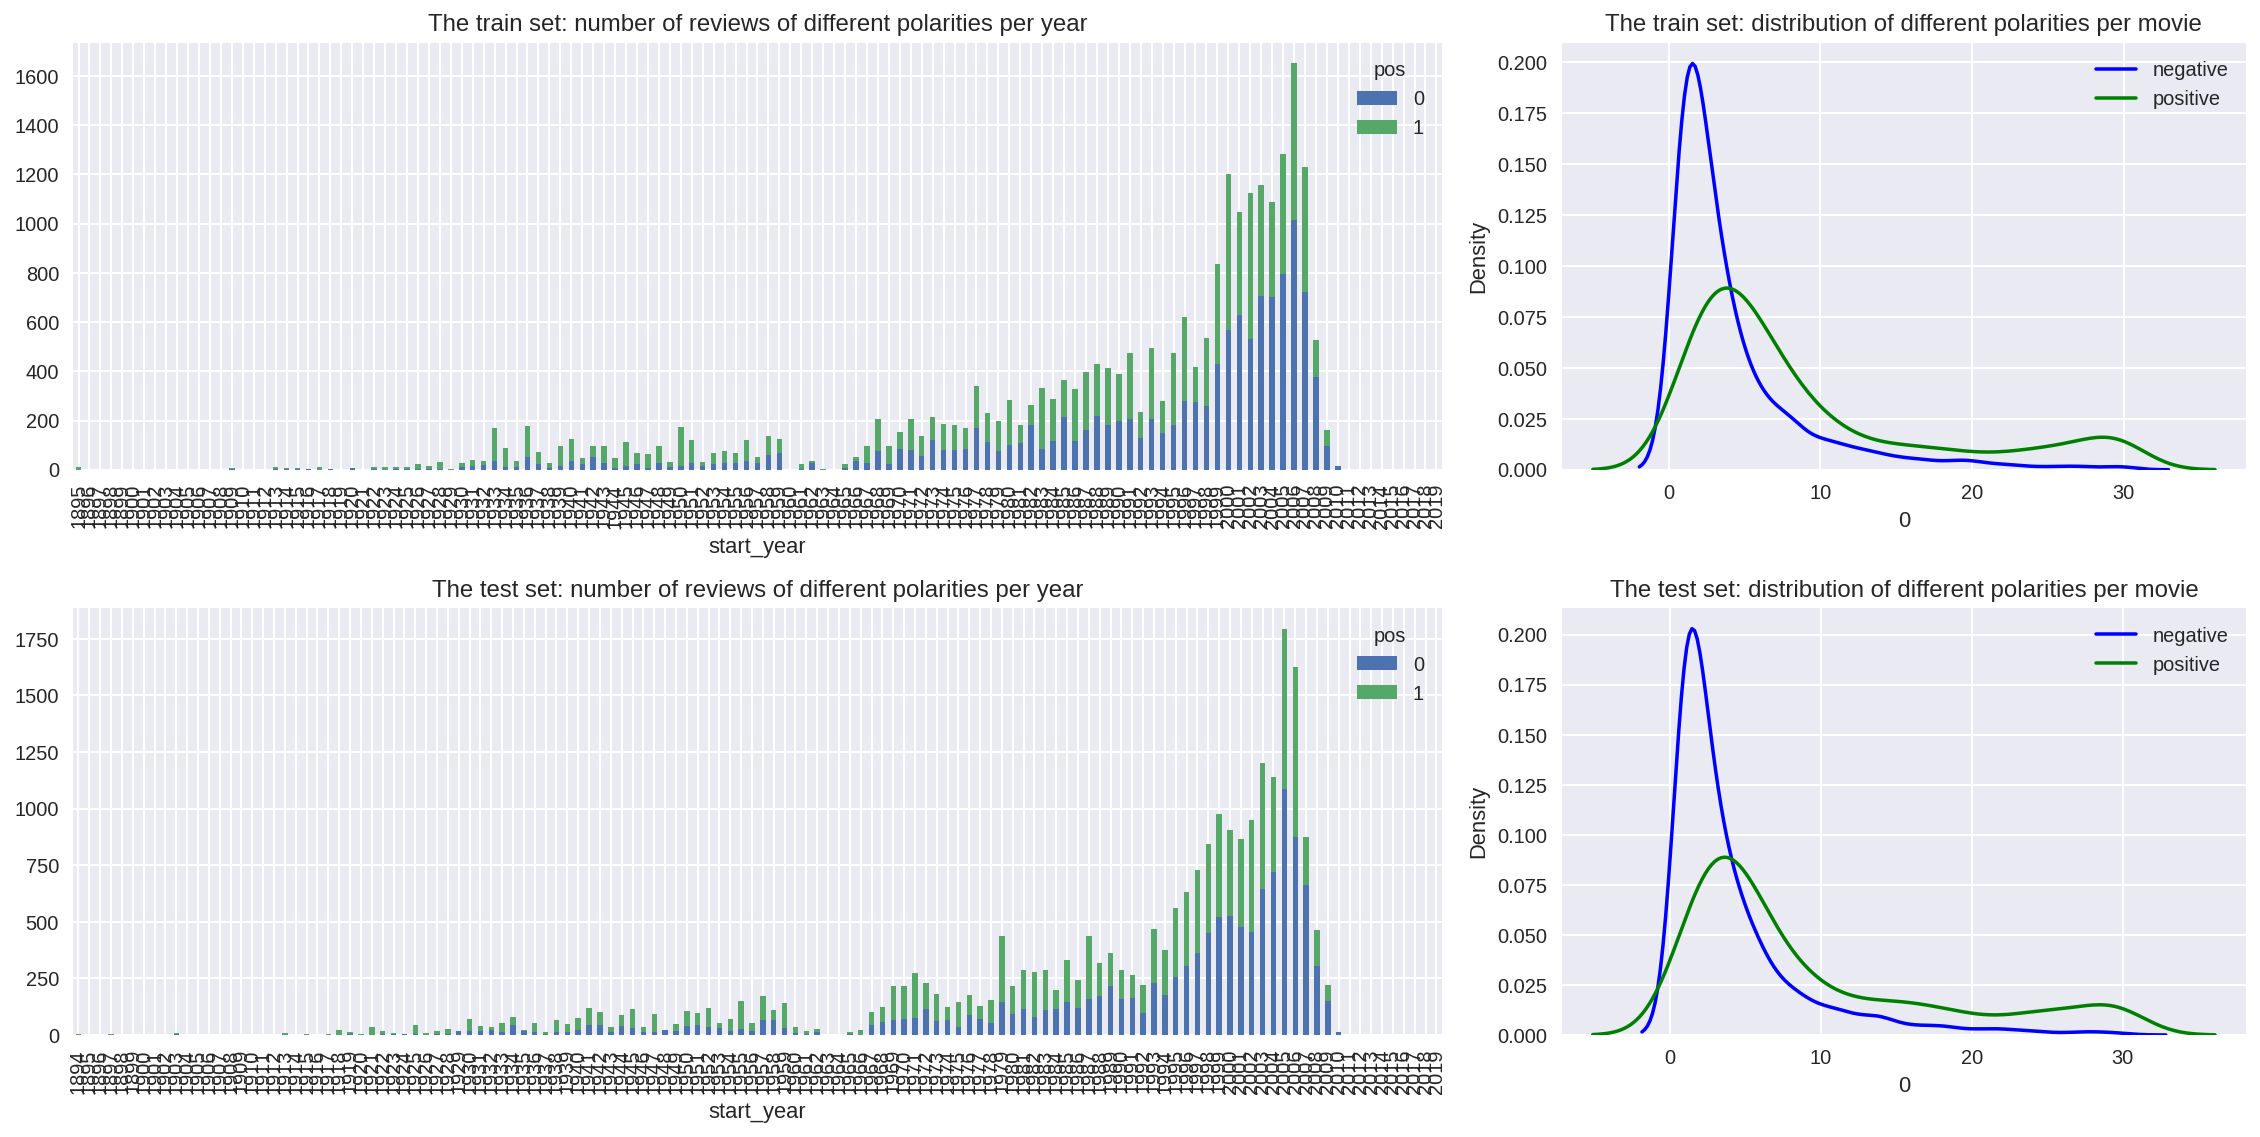

In [84]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)#, kernel='epa')
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)#, kernel='epa')
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)#, kernel='epa')
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)#, kernel='epa')
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Classes are balanced.

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	 
Ok, would be nice if you added some more of your thoughts on what we can see in this EDA :)
	  
</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [10]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    plt.show()
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [11]:
import spacy

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
# !python3 -m spacy download en_core_web_sm --quiet

In [13]:
nltk.download(['stopwords', 'punkt', 'wordnet'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [14]:
stop_words = set(nltk_stopwords.words('english'))

In [15]:
nltk_lemmatizer = WordNetLemmatizer() 

In [29]:
spacy.prefer_gpu()
spacy_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [38]:
def lemmatize(corpus, method='spacy'):
    
    def nltk_lem(string):
        return ' '.join([nltk_lemmatizer.lemmatize(token) for token in word_tokenize(string)] )
    
    
    def spacy_lem(string):
        return ' '.join([token.lemma_ for token in spacy_nlp(string)])
        
        
    if method == 'nltk':
        return corpus.apply(nltk_lem)
    elif method == 'spacy':
        return corpus.apply(spacy_lem)
    else:
        return corpus
    
# lemmatize(X_train[:2], 'spacy')

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Function for lemmatization is correct
	  
</div>

In [18]:
df_reviews['review_norm'] = df_reviews['review'].str.replace(r"[^a-zA-Z']", ' ', regex=True).str.lower()

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Normalization looks good
	  
</div>

In [ ]:
# create_pipeline(DummyClassifier())[0].fit_transform(lemmatize(df_reviews['review_norm'][:2])).toarray()

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [20]:
X_train = df_reviews_train['review_norm']
y_train = train_target

In [21]:
X_test = df_reviews_test['review_norm']
y_test = test_target

## Working with models

In [22]:
random_state = 42

### Pipeline

In [23]:
from sklearn.pipeline import make_pipeline

def create_pipeline(model):
    return make_pipeline(
        TfidfVectorizer(stop_words=stop_words),
        model)

### Model 0 - Constant

In [27]:
from sklearn.dummy import DummyClassifier

stratified
          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


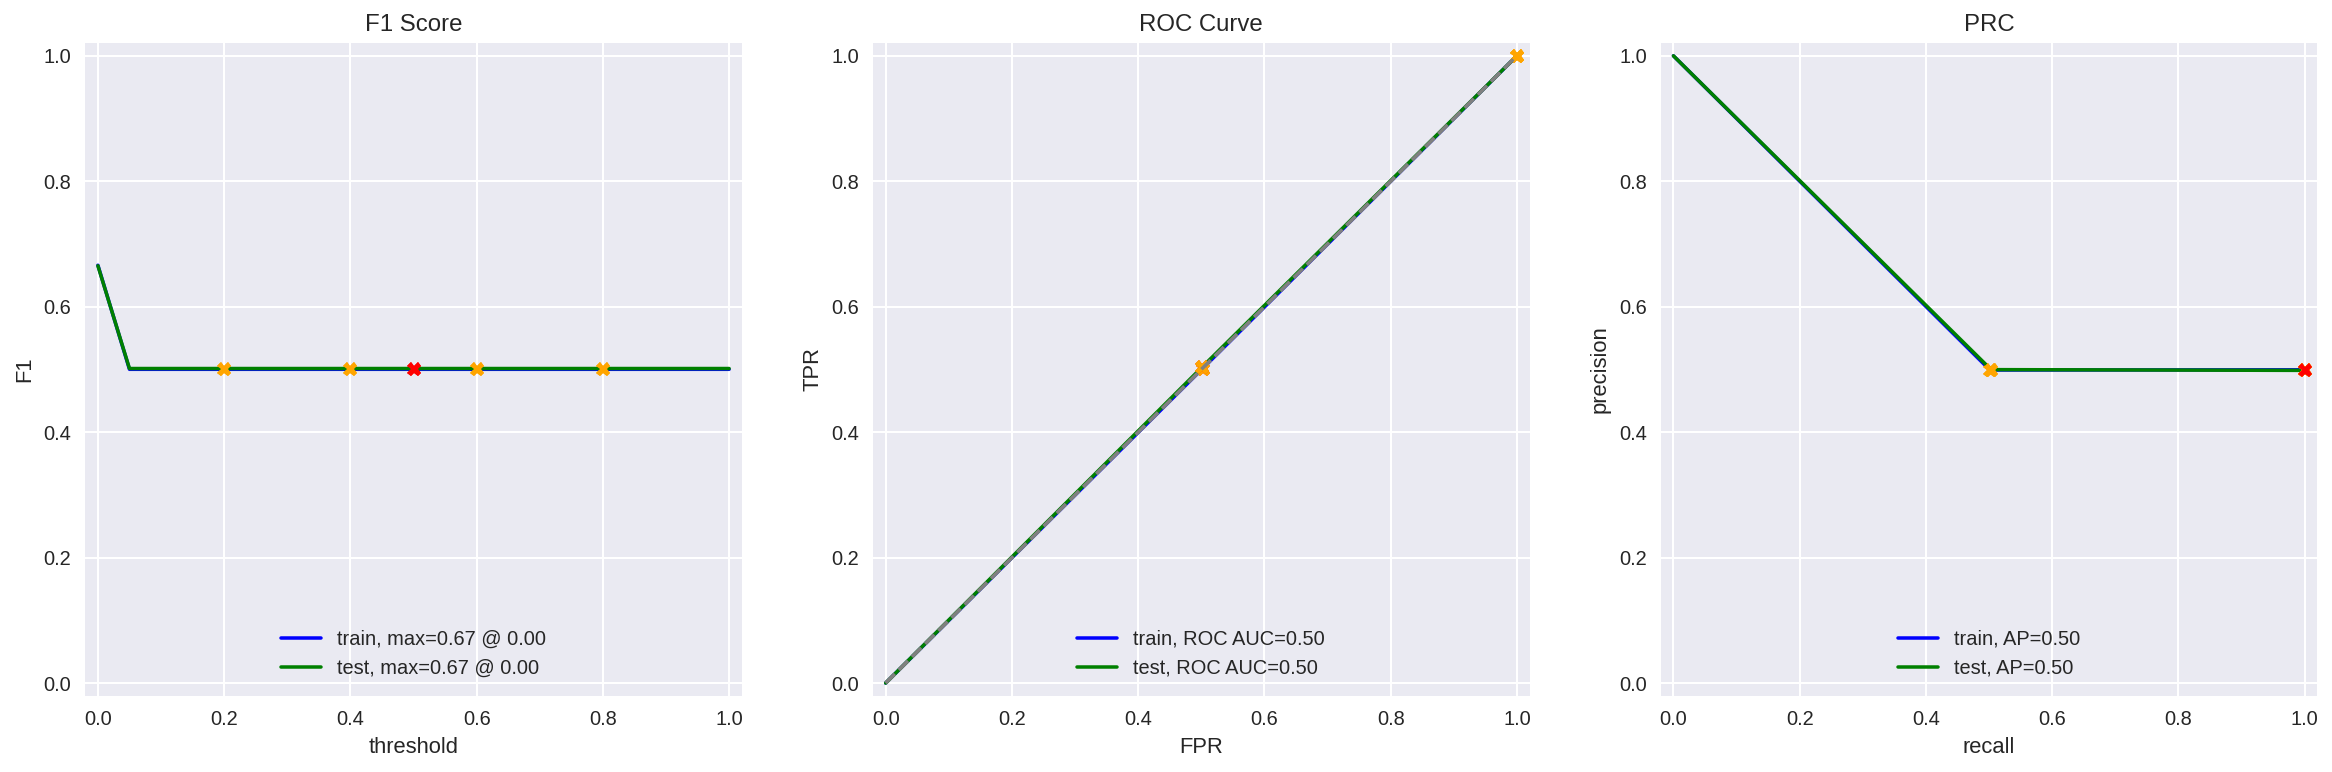


most_frequent
          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


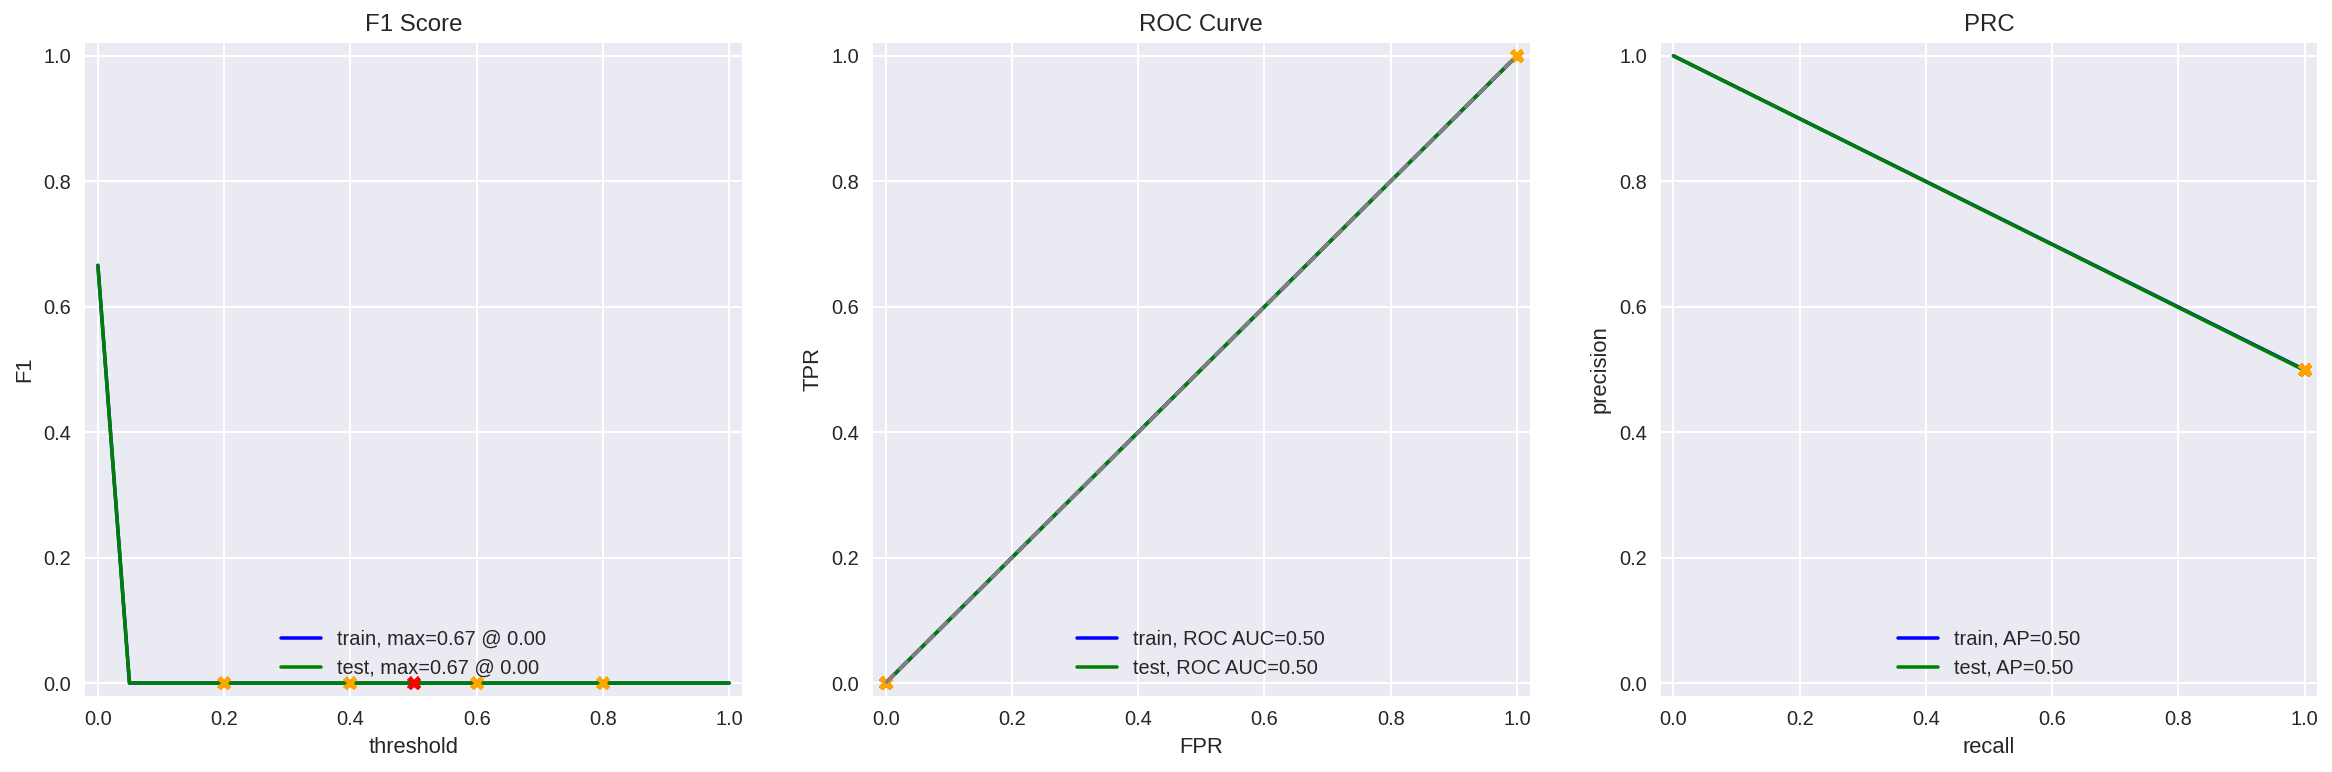


prior
          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


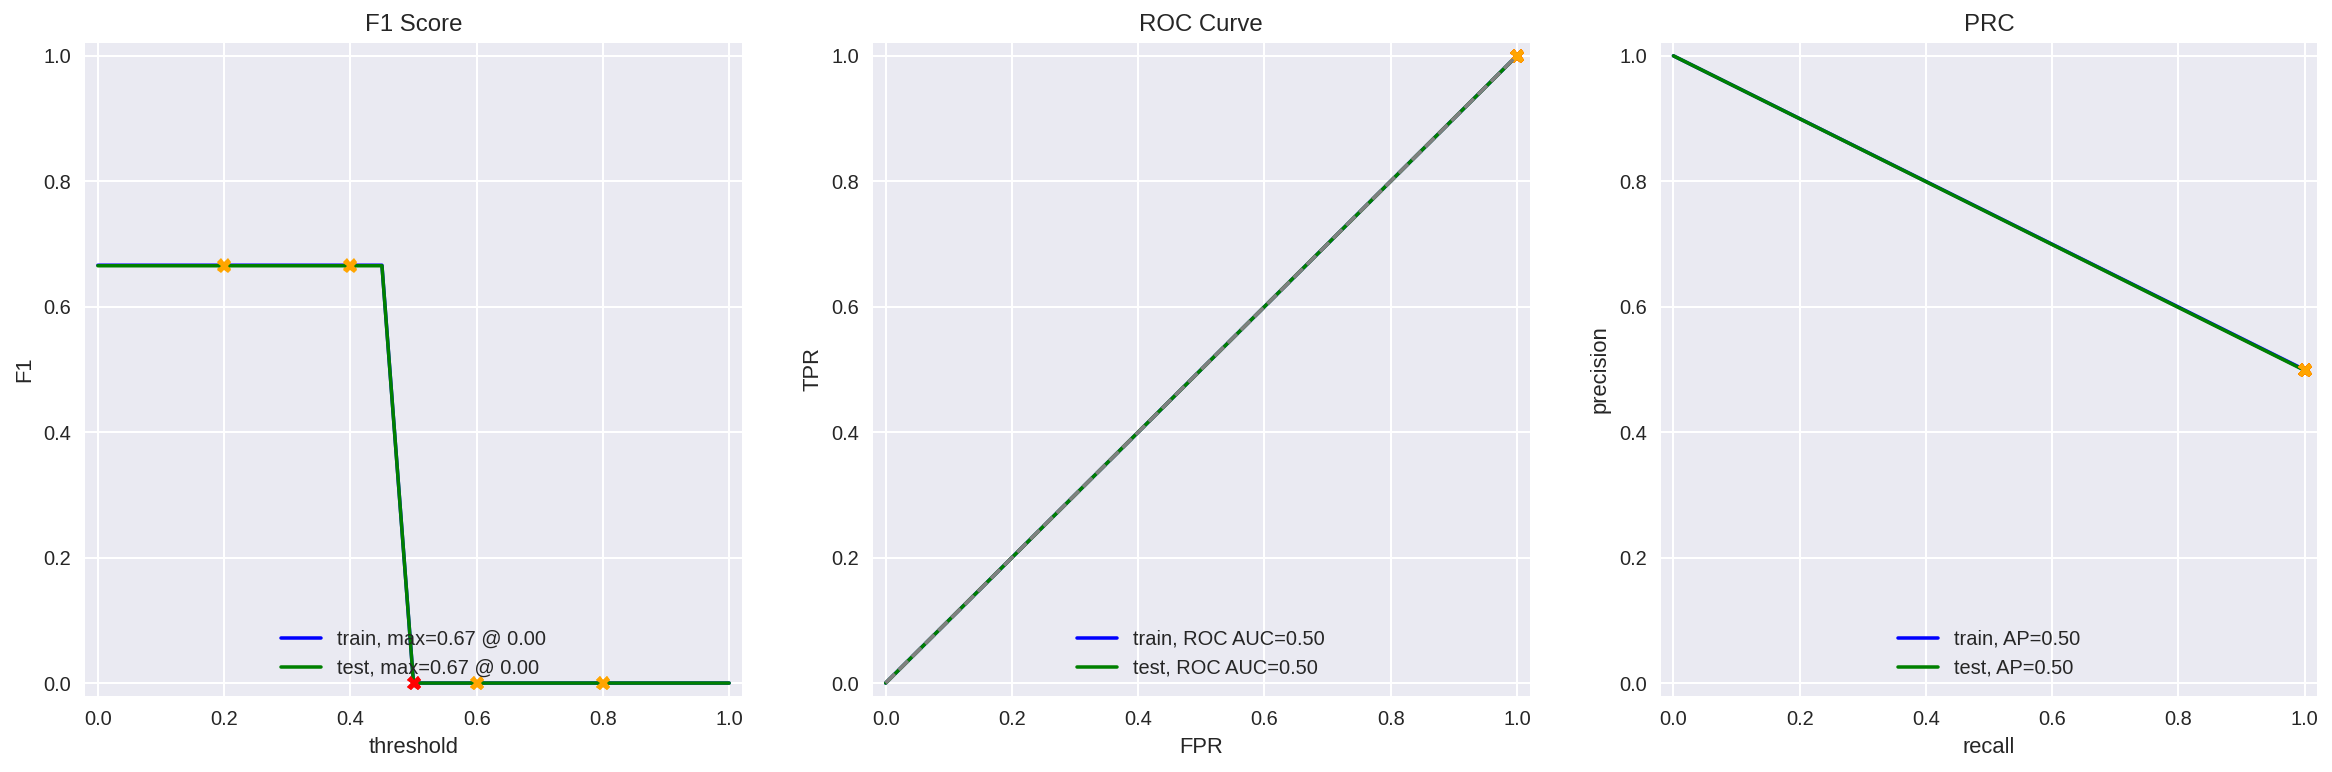


uniform
          train  test
Accuracy   0.51   0.5
F1         0.51   0.5
APS        0.50   0.5
ROC AUC    0.50   0.5


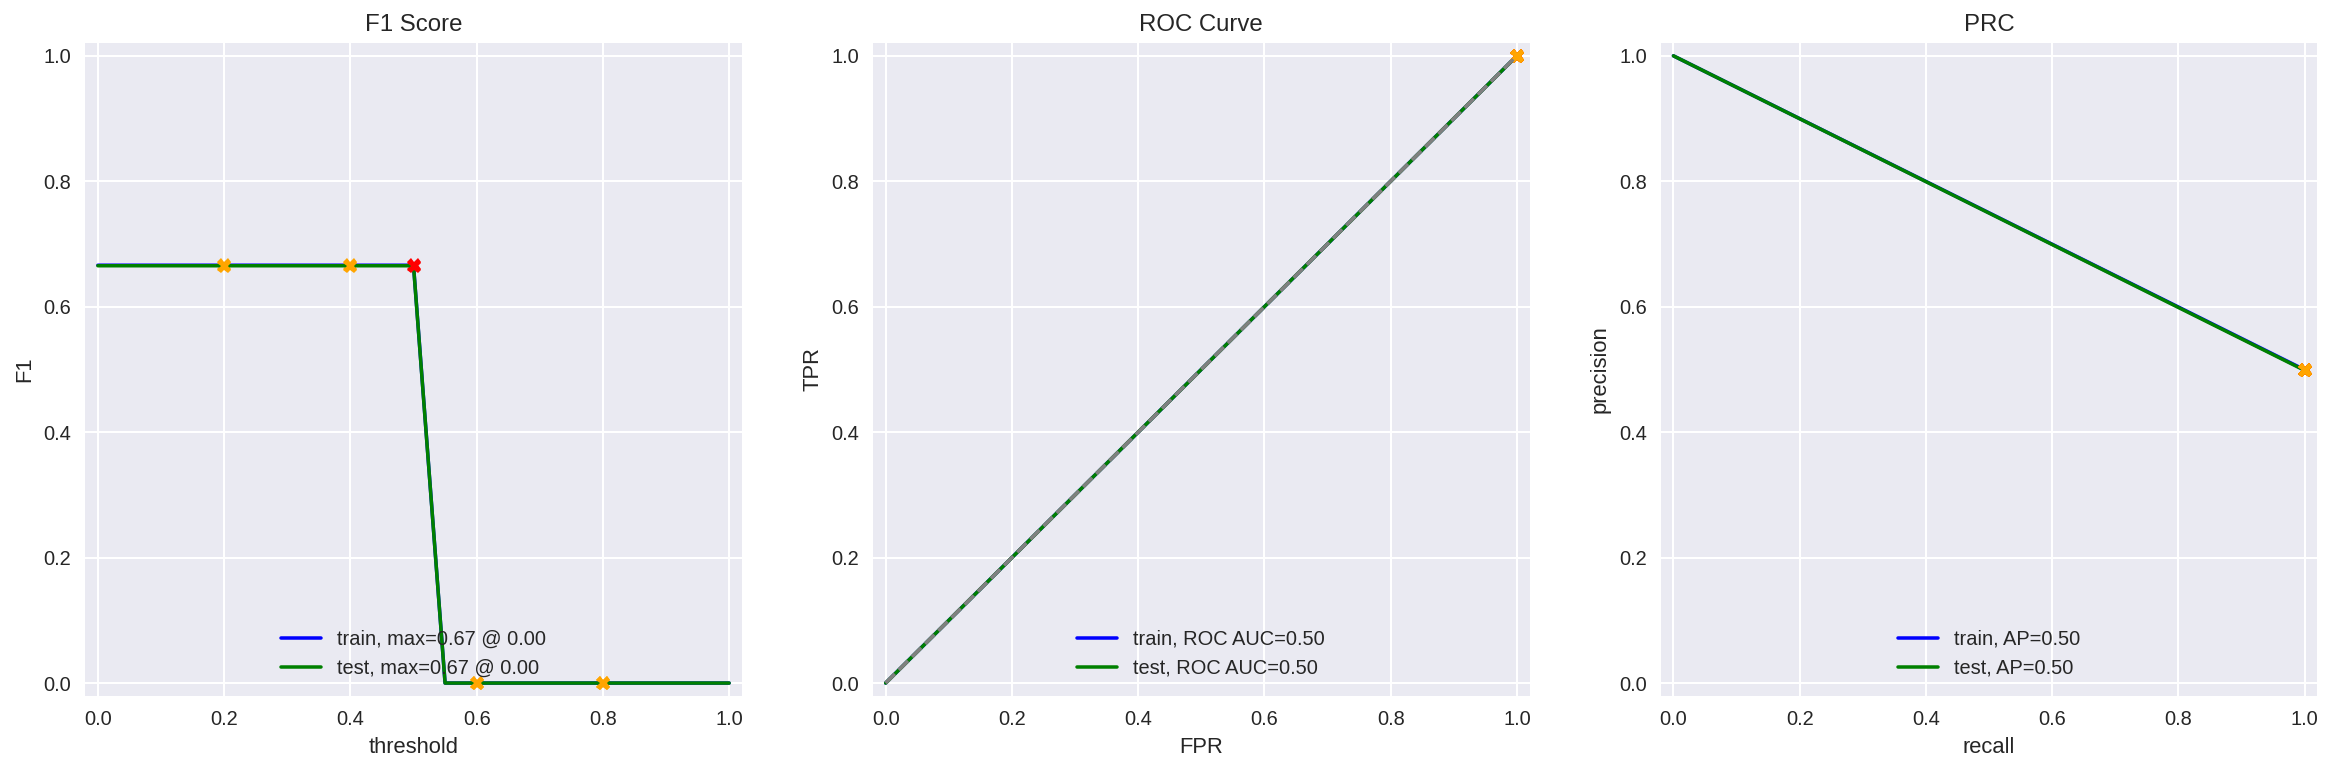

In [28]:
for strategy in ["stratified", "most_frequent", "prior", "uniform"]:
    print(strategy)
    dummy = create_pipeline(DummyClassifier(strategy=strategy, random_state=random_state))
    dummy.fit(X_train, y_train)
    evaluate_model(dummy, X_train, y_train, X_test, y_test)
    print()

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Ok, we have a baseline!
	  
</div>

### Model 1 - NLTK, TF-IDF and LR

In [ ]:
# import nltk

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression

# from nltk.corpus import stopwords

In [ ]:
# stop_words = set(nltk_stopwords.words('english'))

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
train_features_1 = lemmatize(X_train, 'nltk')

In [32]:
test_features_1 = lemmatize(X_test, 'nltk')

In [33]:
model_1 = create_pipeline(LogisticRegression(random_state=random_state))

In [34]:
model_1.fit(train_features_1, train_target);

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


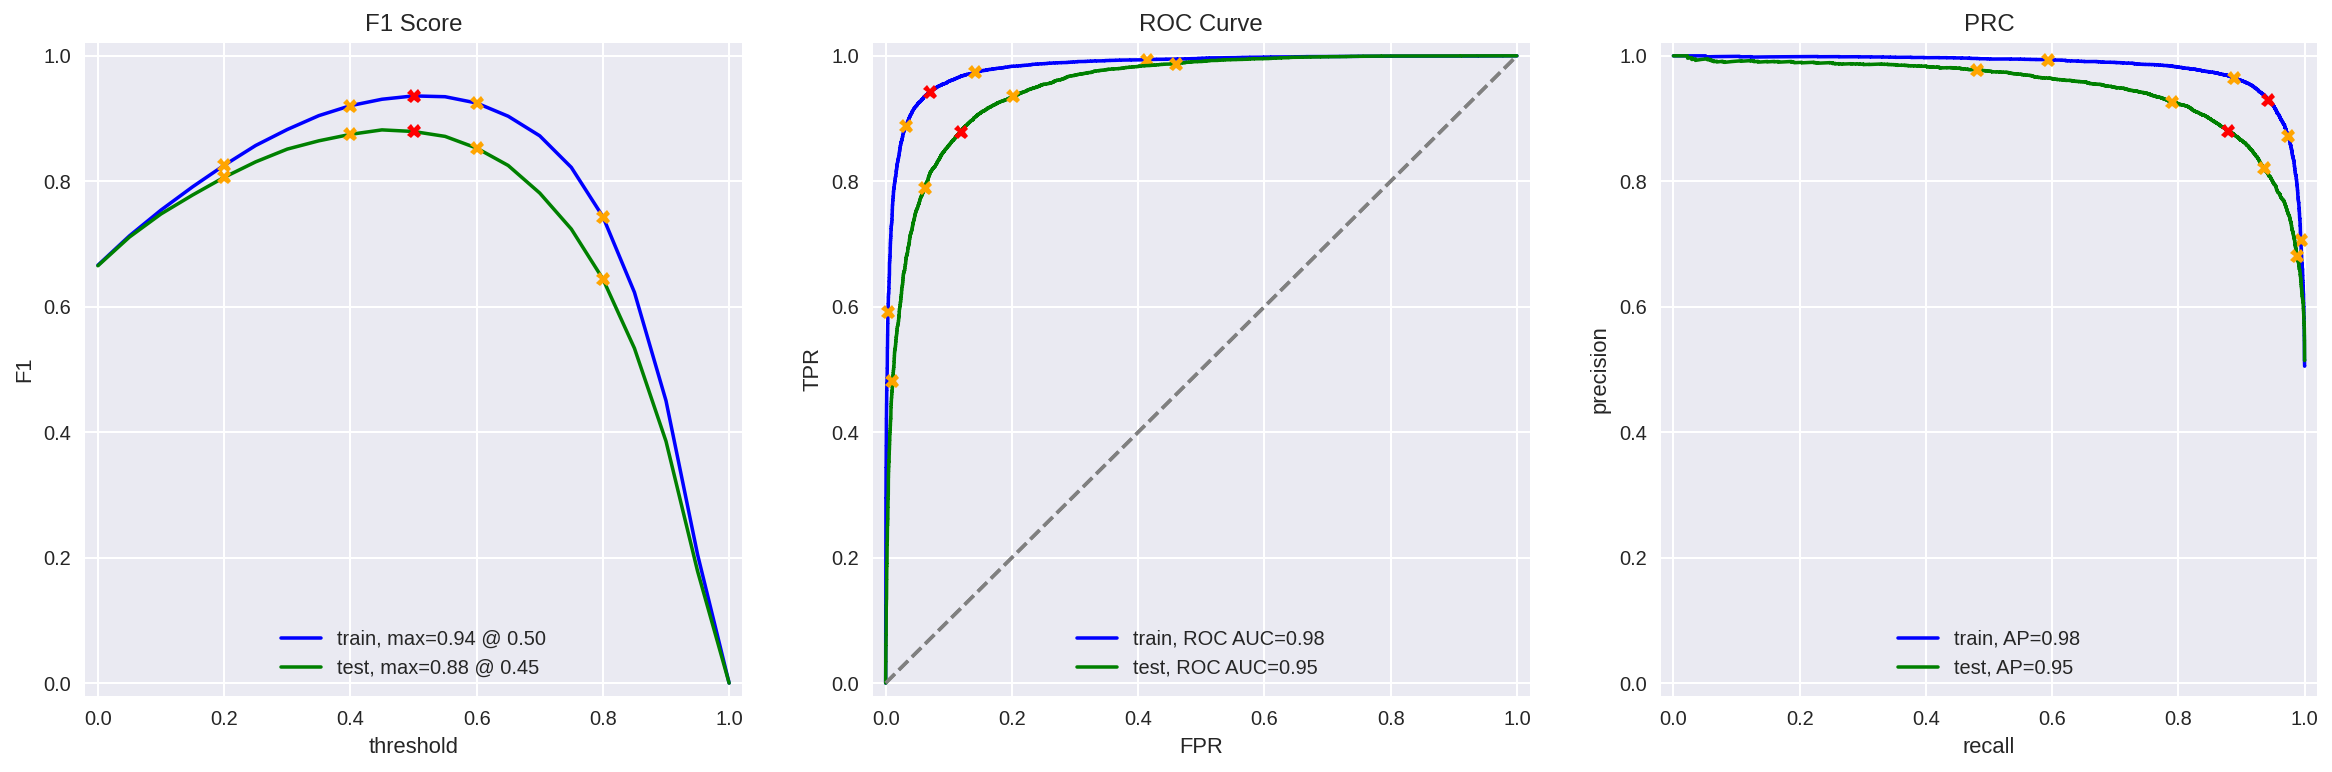

In [35]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [ ]:
# import spacy

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
# def text_preprocessing_3(text):
    
#     doc = nlp(text)
#     #tokens = [token.lemma_ for token in doc if not token.is_stop]
#     tokens = [token.lemma_ for token in doc]
    
#     return ' '.join(tokens)

In [39]:
train_features_3 = lemmatize(X_train, 'spacy')

In [40]:
test_features_3 = lemmatize(X_test, 'spacy')

In [41]:
model_3 = create_pipeline(LogisticRegression(random_state=random_state))

In [42]:
model_3.fit(train_features_3, train_target);

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


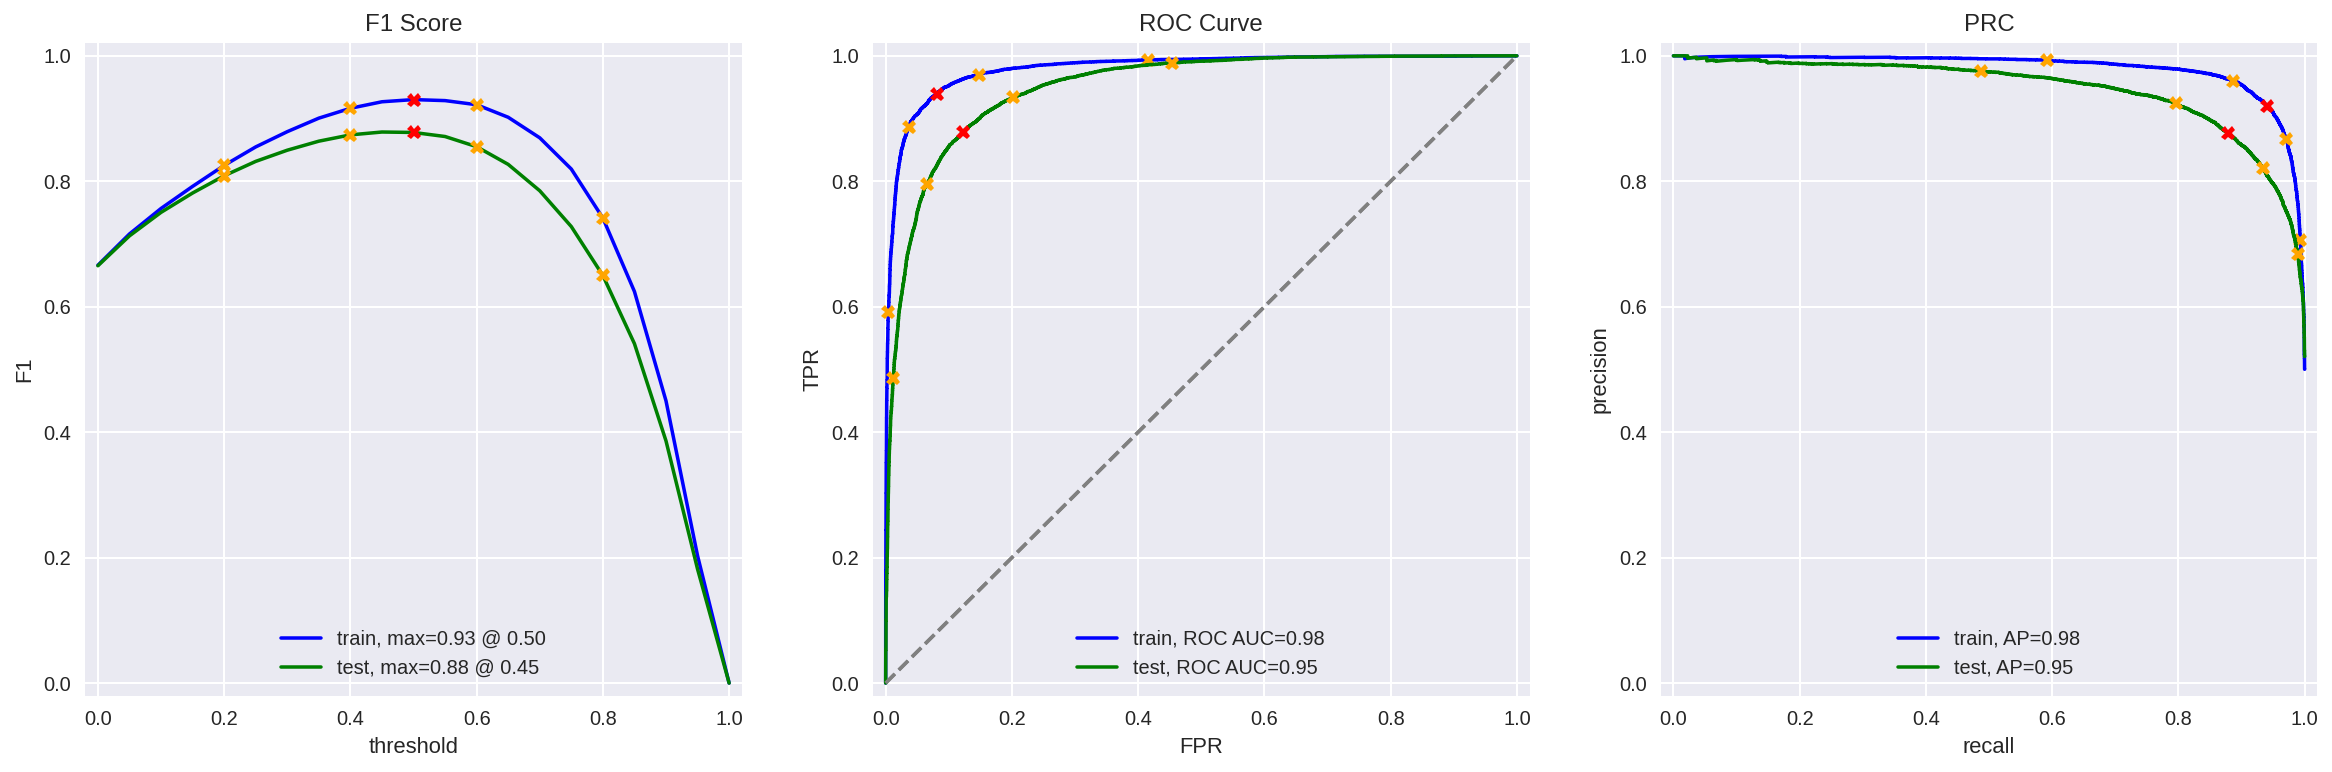

In [43]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [44]:
from lightgbm import LGBMClassifier

In [60]:
model_4 = create_pipeline(LGBMClassifier(random_state=random_state))

In [61]:
model_4.fit(train_features_3, train_target);

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


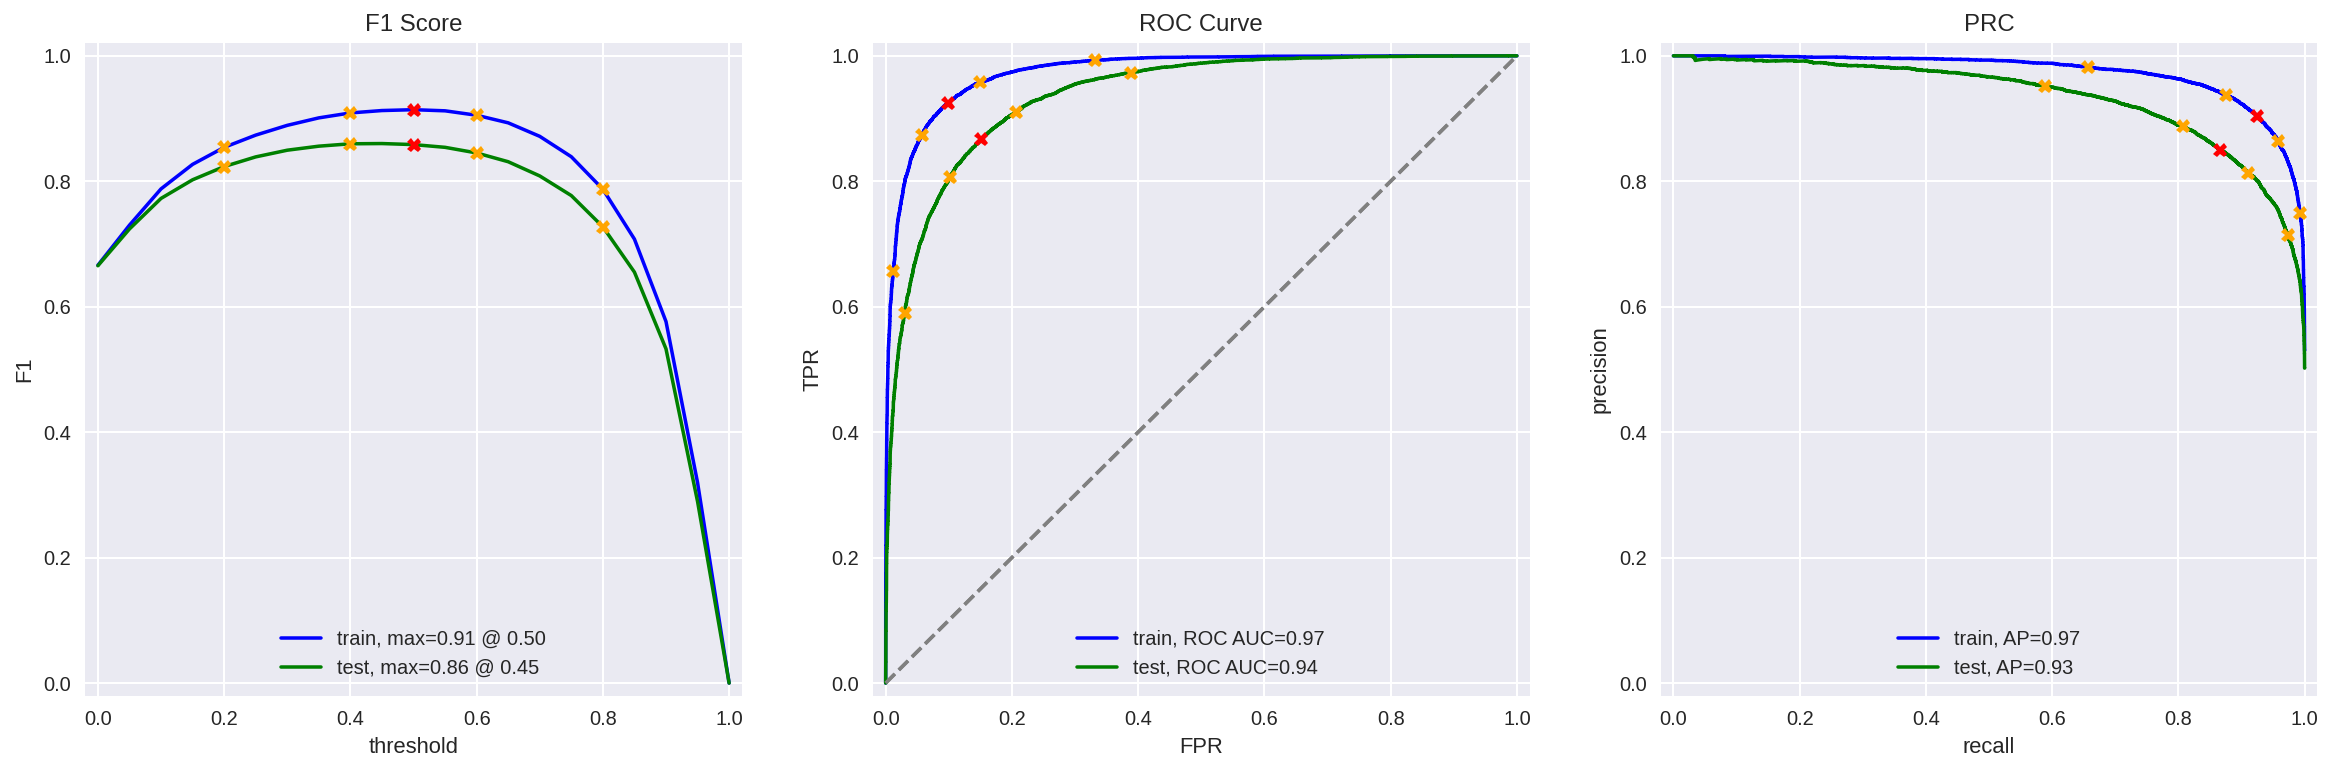

In [62]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Excellent! You tried lemmatizing the text with spacy and nltk, vectorized the text data using TF-IDF and used the resulting features to train a couple of different models. Great use of pipelines!
	  
</div>

###  Model 9 - BERT

In [48]:
!pip install --q transformers

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 36.1 MB/s 
     |████████████████████████████████| 895 kB 53.9 MB/s 
     |████████████████████████████████| 596 kB 47.1 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 


In [49]:
import torch
import transformers

In [50]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [97]:
# padded_sequences = tokenizer(X_train[:2].tolist(), padding=True)

In [51]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # ids = texts.apply(
    #     lambda x: tokenizer.encode(x.lower(), 
    #                                add_special_tokens=True, 
    #                                truncation=True, 
    #                                max_length=max_length))
    
    # ids_list = ids.apply(lambda x:np.pad(x, (0, max_length - len(x)), mode='constant'))
    # attention_mask_list = ids_list.apply(lambda x:np.where(x != 0, 1, 0))

    tokenized = tokenizer(texts.tolist(), max_length=max_length, padding='max_length', truncation=True)
    ids_list = tokenized['input_ids']
    attention_mask_list = tokenized['attention_mask']

    # print(np.array([len(l) for l in ids_list]))
    # print(np.array(attention_mask_list))
      
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # print(ids_batch)
        
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [52]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

Using the cuda device.


  0%|          | 0/238 [00:00<?, ?it/s]

In [53]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796,)


In [54]:
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

Using the cuda device.


  0%|          | 0/236 [00:00<?, ?it/s]

In [55]:
print(df_reviews_test['review_norm'].shape)
print(test_features_9.shape)
print(test_target.shape)

(23535,)
(23535, 768)
(23535,)


In [56]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


          train  test
Accuracy   0.87  0.86
F1         0.87  0.86
APS        0.94  0.94
ROC AUC    0.94  0.94


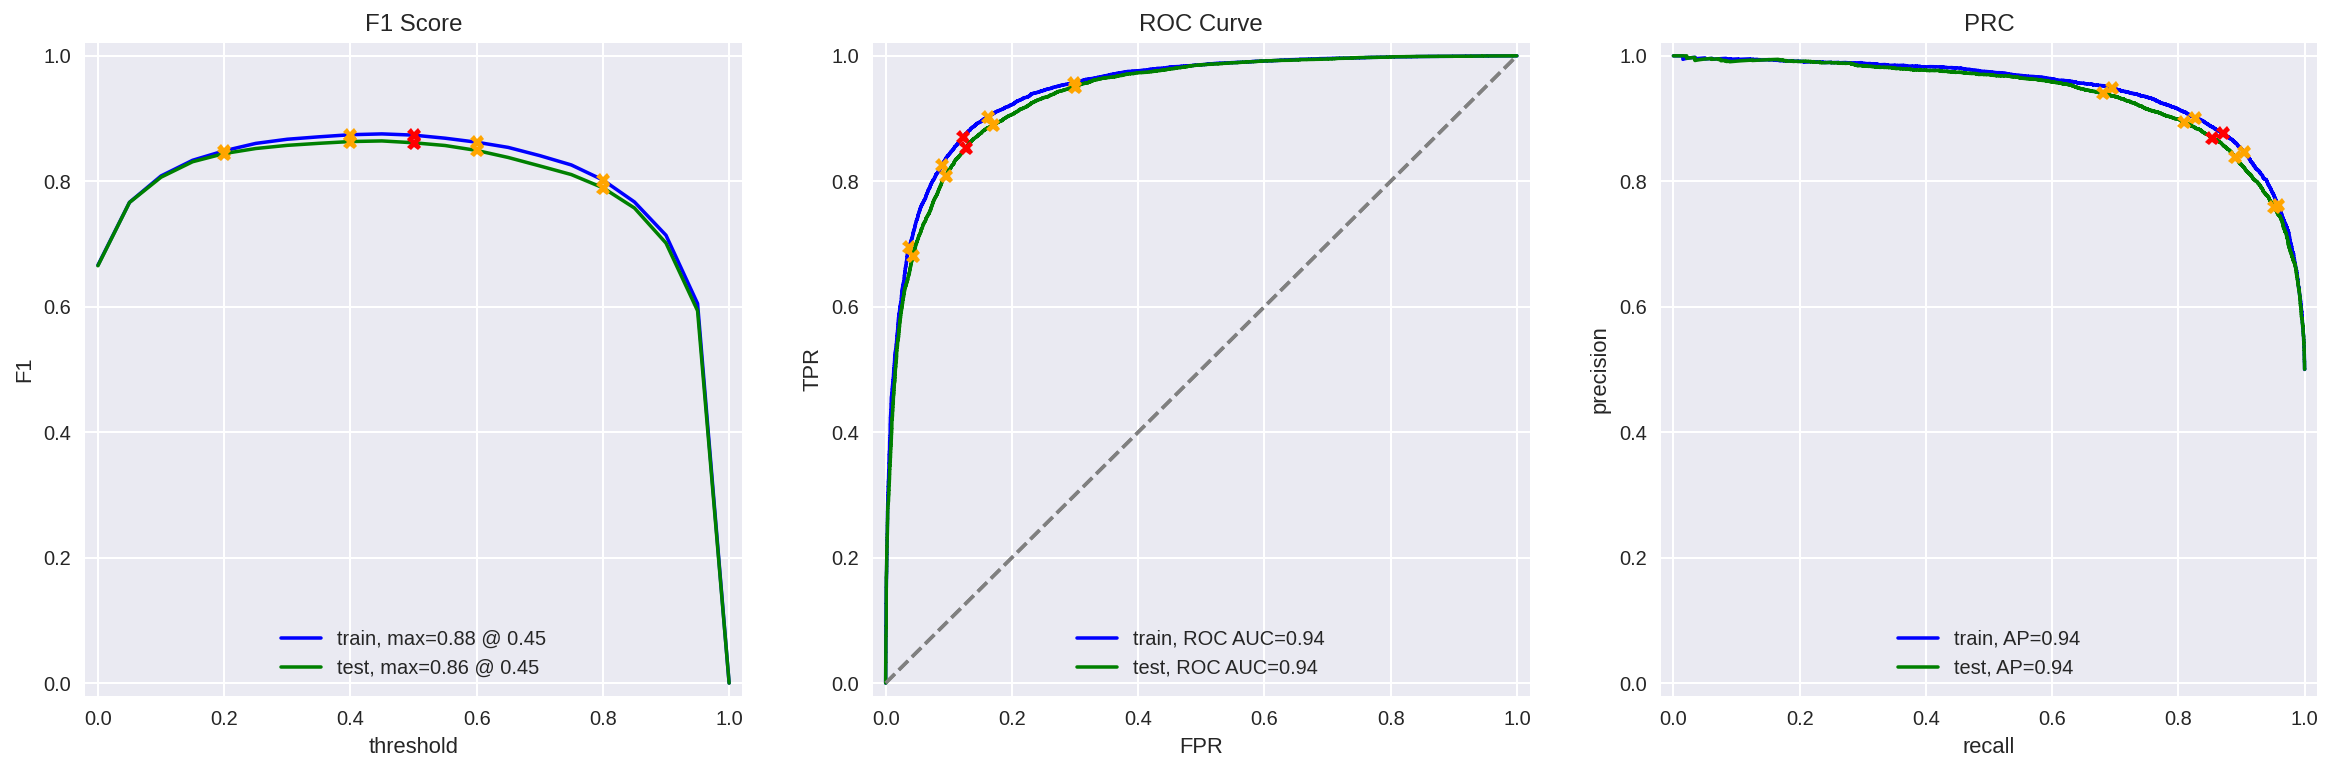

In [78]:
model_9 = LogisticRegression(random_state=random_state)
model_9.fit(train_features_9, train_target)
evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target)

          train  test
Accuracy   0.92  0.84
F1         0.92  0.83
APS        0.98  0.92
ROC AUC    0.98  0.92


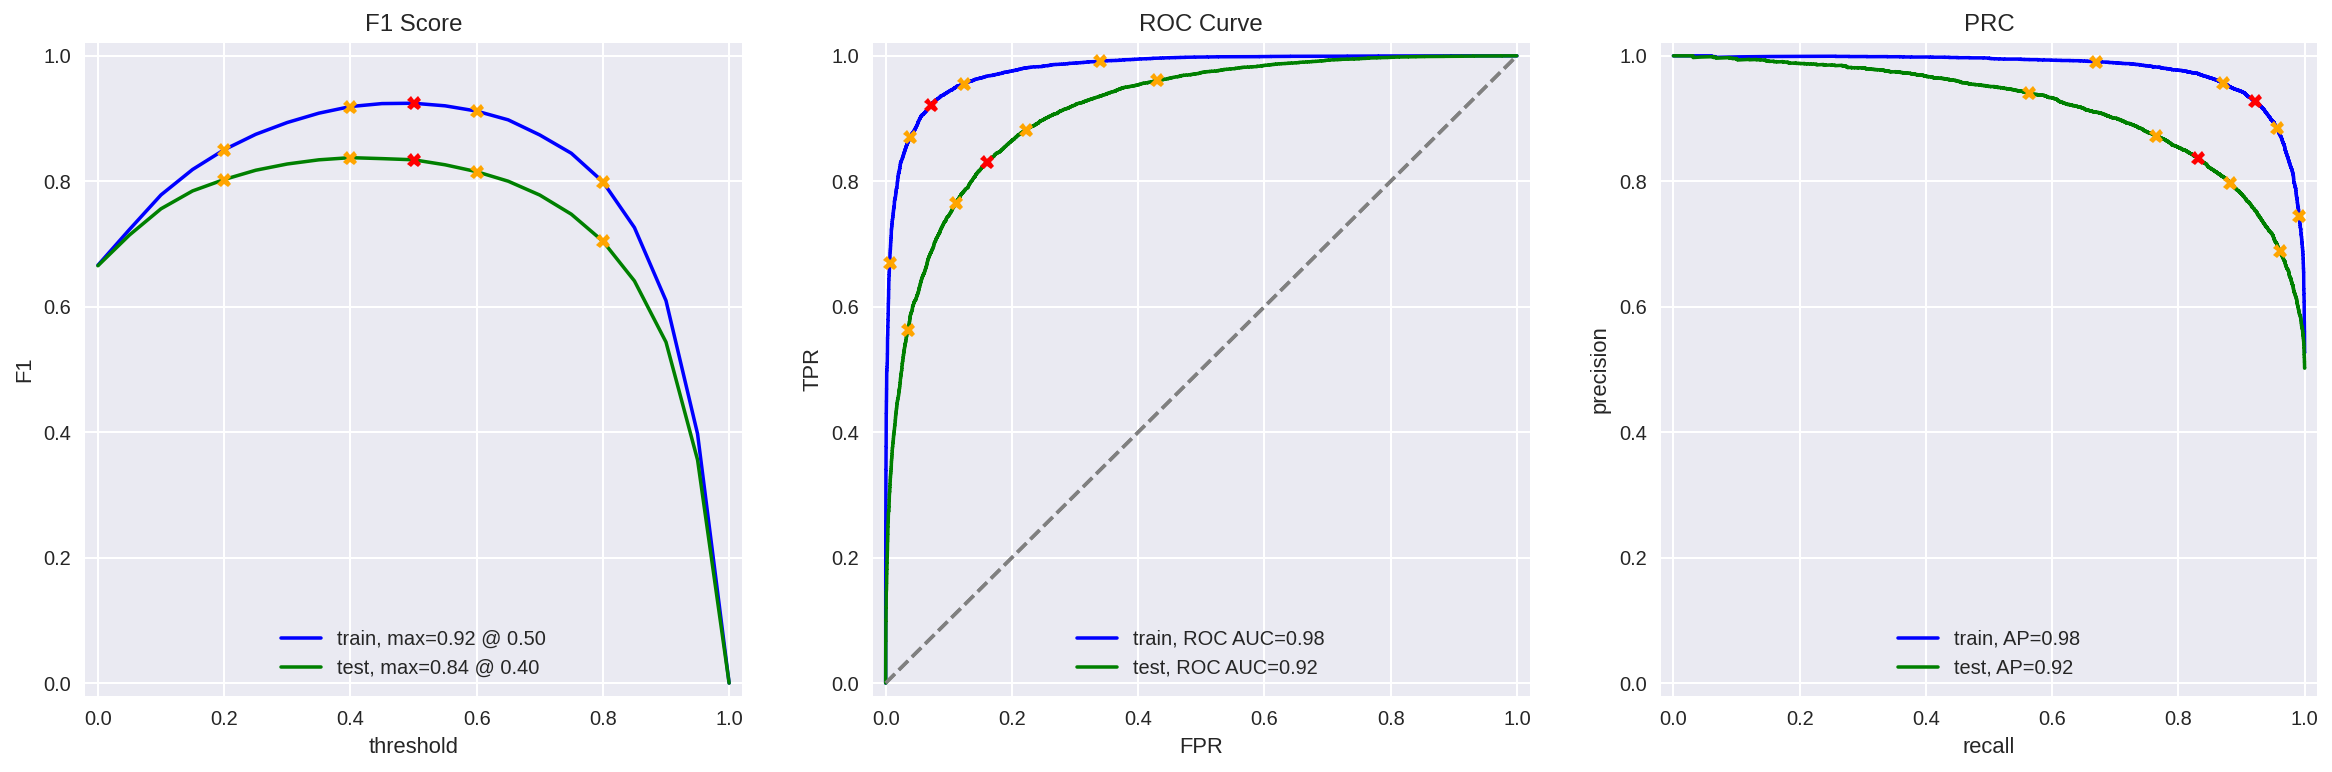

In [63]:
lgbm_model = LGBMClassifier(random_state=random_state)
lgbm_model.fit(train_features_9, train_target)
evaluate_model(lgbm_model, train_features_9, train_target, test_features_9, test_target)

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Awesome! You successfully used BERT to generate embeddings of the text data.
	  
</div>

## My Reviews

In [64]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.replace(r"[^a-zA-Z']", ' ', regex=True).str.lower()

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i real...


### Model 2

In [74]:
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_1.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it  not my kind of movie 
0.18:  well  i was bored and felt asleep in the middle of the movie 
0.57:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.39:  i didn't expect the reboot to be so good  writers really cared about the source material
0.49:  the movie had its upsides and downsides  but i feel like overall it's a decent flick  i could see my
0.09:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.89:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 3

In [75]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it  not my kind of movie 
0.23:  well  i was bored and felt asleep in the middle of the movie 
0.47:  i was really fascinated with the movie
0.33:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.43:  i didn't expect the reboot to be so good  writers really cared about the source material
0.43:  the movie had its upsides and downsides  but i feel like overall it's a decent flick  i could see my
0.05:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.91:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 4

In [76]:
texts = my_reviews['review_norm']

# tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(texts)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it  not my kind of movie 
0.52:  well  i was bored and felt asleep in the middle of the movie 
0.60:  i was really fascinated with the movie
0.47:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.68:  i didn't expect the reboot to be so good  writers really cared about the source material
0.65:  the movie had its upsides and downsides  but i feel like overall it's a decent flick  i could see my
0.22:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.81:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 9

In [79]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.35:  i did not simply like it  not my kind of movie 
0.01:  well  i was bored and felt asleep in the middle of the movie 
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.23:  i didn't expect the reboot to be so good  writers really cared about the source material
0.97:  the movie had its upsides and downsides  but i feel like overall it's a decent flick  i could see my
0.06:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.96:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Models were applied to custom reviews correctly
	  
</div>

## Conclusions

### Model performance on dataset

#### Dummy baseline 
    F1=0.5, ROC_AUC=0.5

#### NLTK, TF-IDF and LR:
    Train: F1=0.94, ROC_AUC=0.98
    Test : F1=0.88, ROC_AUC=0.95

#### spaCy, TF-IDF and LR: 
    Train: F1=0.93, ROC_AUC=0.98
    Test : F1=0.88, ROC_AUC=0.95

#### spaCy, TF-IDF and LGBMClassifier: 
    Train: F1=0.91, ROC_AUC=0.97
    Test : F1=0.86, ROC_AUC=0.94
  
#### BERT and LR: 
    Train: F1=0.87, ROC_AUC=0.94
    Test : F1=0.86, ROC_AUC=0.94

All of the models performed on-par on the train/test dataset (with the first one having slighly better results).  
BERT + LR had the least amount of overfitting (practically none) - which means it is probably best suited to take on new unseen data.

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	  
> BERT + LR had the least amount of overfitting (practically none) - which means it is probably best suited to take on new unseen data.
    
Not sure I agree with this logic: the first model still has a better test set performance. Overfitting really comes into play when the model's train set performance still increases, but its test set performance starts decreasing. I guess it would make sense to use this logic for model selection if their test set performance was equal, but not otherwise.
	  
</div>

### Model performance on custom reviews

BERT + LR did best on new custom reviews, with sharp probabilities closer to the polars (0 or 1) - it is not overfit.  

spaCy, TF-IDF and LGBMClassifier did worst:  
For example, it ranked 

    "even the actors looked really old and disinterested  and they got paid to be in the movie  what a so" 
with 0.47 (close to neutral), when it's a negative review.

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	  
Note that the custom reviews are used just as an illustration: ultimately, it shouldn't be used to judge the models performance, because it is just a very small test set. The better indicator is the real test set performance.
	  
</div>

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions